In [1]:
#LSTM model made with weather data 
#this version predicts the temperature as a function of the other variables. Predict1.pynb will incorporate PS data as well

    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('df PS and weather.csv')

In [2]:
df = df.iloc[:,51:]


In [19]:
df.keys()

Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'Clear', 'Overcast', 'Partially cloudy', 'Rain',
       'Rain, Overcast', 'Rain, Partially cloudy', 'rain'],
      dtype='object')

In [4]:
#drop columns that aren't useful
#df.drop(['name', 'icon', 'stations'], axis=1, inplace=True)
df.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,...,solarenergy,uvindex,severerisk,Clear,Overcast,Partially cloudy,Rain,"Rain, Overcast","Rain, Partially cloudy",rain
0,4.2,1.8,2.2,86.73,0.0,0.0,0.0,0.0,13.70,9.700,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.2,1.8,2.2,86.73,0.0,0.0,0.0,0.0,11.35,9.675,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.2,1.8,2.2,86.73,0.0,0.0,0.0,0.0,9.00,9.650,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.2,1.8,2.2,86.73,0.0,0.0,0.0,0.0,6.65,9.625,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.2,1.8,2.2,86.73,0.0,0.0,0.0,0.0,4.30,9.600,...,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': 'Catania Weather Data'}>

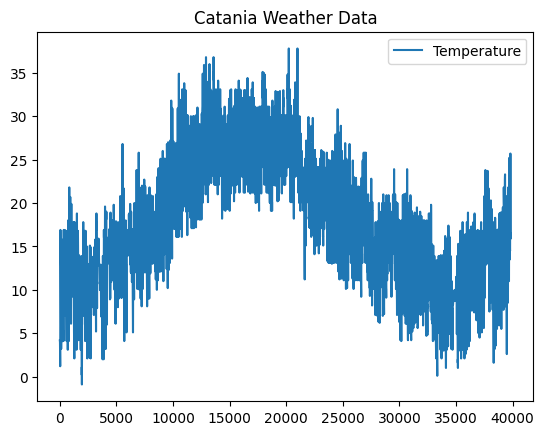

In [5]:
df['temp'].plot(label='Temperature', title='Catania Weather Data', legend=True)

In [3]:
# make variable x = all columns of df except first column  
#X = df.iloc[:, 3:] #everything except first two columns
X = df.iloc[:, 1:]
y = df.iloc[:, 0:1] #select response variable

# give dimension of X and y
#print(X.iloc[0:5, 15:])

In [4]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

#first 600 for training

X_train = X_ss[:38000, :]
X_test = X_ss[38000:, :]

y_train = y_mm[:38000, :]
y_test = y_mm[38000:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (38000, 24) (38000, 1)
Testing Shape (1837, 24) (1837, 1)


In [5]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([38000, 1, 24]) torch.Size([38000, 1])
Testing Shape torch.Size([1837, 1, 24]) torch.Size([1837, 1])


In [6]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [7]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 24 #number of features
hidden_size = 5 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [8]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 0, loss: 0.14406
Epoch: 100, loss: 0.00601
Epoch: 200, loss: 0.00300
Epoch: 300, loss: 0.00139
Epoch: 400, loss: 0.00069
Epoch: 500, loss: 0.00044
Epoch: 600, loss: 0.00031
Epoch: 700, loss: 0.00023
Epoch: 800, loss: 0.00018
Epoch: 900, loss: 0.00013


In [9]:
df_X_ss = ss.transform(df.iloc[:, 1:]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 0:1]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

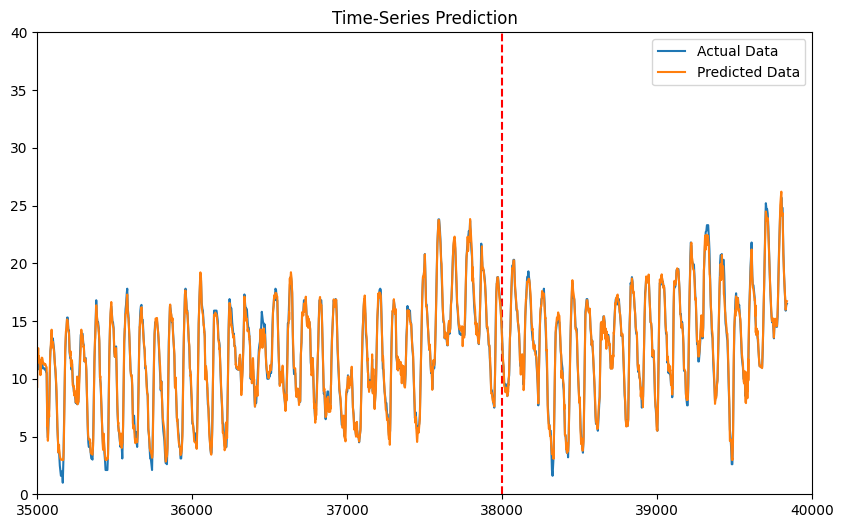

In [10]:


train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=38000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
ax = plt.gca()
xmin = 35000  
xmax = 40000
ymin = 0
ymax = 40
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show() 